[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fadheladlansyah/chest-xray-pneumonia/blob/master/eda.ipynb)

# Setting kaggle

In [1]:
# to upload files
from google.colab import files

# install Kaggle library
# !pip list
# !pip install -q kaggle

In [2]:
# upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop

import requests
from io import BytesIO

import json
import zipfile

from random import sample
from datetime import datetime
from tqdm import tqdm, auto
import shutil
import os
import gc
import warnings
warnings.filterwarnings("ignore")

# Load Data

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (PNEUMONIA/NORMAL). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [5]:
# download dataset <owner>/<dataset-name>
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.28G/2.29G [00:17<00:00, 231MB/s]
100% 2.29G/2.29G [00:17<00:00, 140MB/s]


In [6]:
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zf:
  zf.extractall()

img_dir = os.path.join(os.getcwd(), 'chest_xray')
test_img_dir = os.path.join(img_dir, 'test')
train_img_dir = os.path.join(img_dir, 'train')
val_img_dir = os.path.join(img_dir, 'val')

# EDA

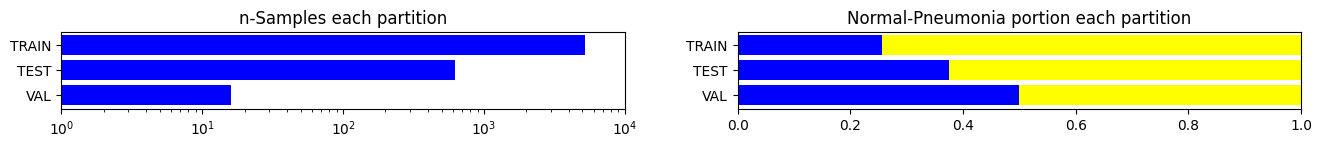

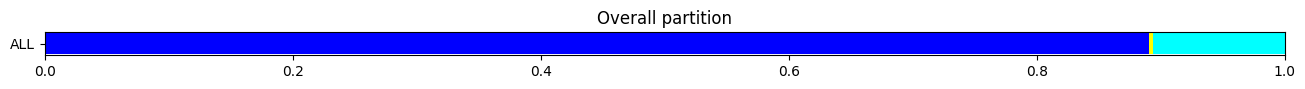

In [7]:
#@title samples partition { display-mode: "form" }

NB_TRAIN_SAMPLES_N = len(os.listdir(os.path.join(train_img_dir, 'NORMAL')))
NB_TRAIN_SAMPLES_P = len(os.listdir(os.path.join(train_img_dir, 'PNEUMONIA')))
NB_TRAIN_SAMPLES = NB_TRAIN_SAMPLES_N + NB_TRAIN_SAMPLES_P

NB_VAL_SAMPLES_N = len(os.listdir(os.path.join(val_img_dir, 'NORMAL')))
NB_VAL_SAMPLES_P = len(os.listdir(os.path.join(val_img_dir, 'PNEUMONIA')))
NB_VAL_SAMPLES = NB_VAL_SAMPLES_N + NB_VAL_SAMPLES_P

NB_TEST_SAMPLES_N = len(os.listdir(os.path.join(test_img_dir, 'NORMAL')))
NB_TEST_SAMPLES_P = len(os.listdir(os.path.join(test_img_dir, 'PNEUMONIA')))
NB_TEST_SAMPLES = NB_TEST_SAMPLES_N + NB_TEST_SAMPLES_P

NB_TOTAL_SAMPLES = NB_TRAIN_SAMPLES + NB_VAL_SAMPLES + NB_TEST_SAMPLES

def chart_partitioning():

  fig = plt.figure(figsize=(16,1))

  ax = fig.add_subplot(1,2,1)
  ax.barh(['VAL'], [NB_VAL_SAMPLES], color='#0000ff')
  ax.barh(['TEST'], [NB_TEST_SAMPLES], color='#0000ff')
  ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES], color='#0000ff')
  ax.set_xscale('log')
  ax.set_xlim((1,1e4))
  ax.set_title('n-Samples each partition');

  ax = fig.add_subplot(1,2,2)
  ax.barh(['VAL'], [NB_VAL_SAMPLES_N/NB_VAL_SAMPLES], color='#0000ff')
  ax.barh(['VAL'], [NB_VAL_SAMPLES_P/NB_VAL_SAMPLES], color='#ffff00',
          left=[NB_VAL_SAMPLES_N/NB_VAL_SAMPLES])
  ax.barh(['TEST'], [NB_TEST_SAMPLES_N/NB_TEST_SAMPLES], color='#0000ff')
  ax.barh(['TEST'], [NB_TEST_SAMPLES_P/NB_TEST_SAMPLES], color='#ffff00',
          left=[NB_TEST_SAMPLES_N/NB_TEST_SAMPLES])
  ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES_N/NB_TRAIN_SAMPLES], color='#0000ff')
  ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES_P/NB_TRAIN_SAMPLES], color='#ffff00',
          left=[NB_TRAIN_SAMPLES_N/NB_TRAIN_SAMPLES])
  ax.set_xlim((0,1))
  ax.set_title('Normal-Pneumonia portion each partition');

  fig = plt.figure(figsize=(16,0.3))
  ax = fig.add_subplot(1,1,1)
  NB_TOTAL_SAMPLES = NB_TEST_SAMPLES + NB_TRAIN_SAMPLES + NB_VAL_SAMPLES
  ax.barh(['ALL'], [NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES], color='#0000ff')
  ax.barh(['ALL'], [NB_VAL_SAMPLES/NB_TOTAL_SAMPLES], color='#ffff00',
          left=[NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES])
  ax.barh(['ALL'], [NB_TEST_SAMPLES/NB_TOTAL_SAMPLES], color='#00ffff',
          left=[(NB_TRAIN_SAMPLES+NB_VAL_SAMPLES)/NB_TOTAL_SAMPLES])
  ax.set_xlim((0,1))
  ax.set_title('Overall partition');

chart_partitioning()

- Validation set too small, it caused high oscilation in the training process. Restructure train, val, test seems worthed, try **~80%, ~10%, ~10%** by moving some train samples to val.
- The imbalance class, there are mote pneumonia case in the dataset.

In [8]:
# count how many samples to move so that train partition ~80%
train_part = NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES
n_to_move = round((train_part - 0.8) * NB_TRAIN_SAMPLES)
# count each n and p samples to move
# later train val have the same N/P proportion
n_to_move_N = round((NB_TRAIN_SAMPLES_N + NB_VAL_SAMPLES_N) /
                    (NB_TRAIN_SAMPLES + NB_VAL_SAMPLES) * n_to_move)
n_to_move_P = n_to_move - n_to_move_N

# move rendom files from one directory to other directory
def move_files_random(from_dir, to_dir, n):
  for filename in sample(os.listdir(from_dir), k=n):
    from_fpath = os.path.join(from_dir, filename)
    to_fpath = os.path.join(to_dir, filename)
    shutil.move(from_fpath, to_fpath)
  display(f"move {n} files from {from_dir} to {to_dir}")

move_files_random(from_dir=os.path.join(train_img_dir, 'NORMAL'),
                  to_dir=os.path.join(val_img_dir, 'NORMAL'),
                  n=n_to_move_N)

move_files_random(from_dir=os.path.join(train_img_dir, 'PNEUMONIA'),
                  to_dir=os.path.join(val_img_dir, 'PNEUMONIA'),
                  n=n_to_move_P)

'move 122 files from /content/chest_xray/train/NORMAL to /content/chest_xray/val/NORMAL'

'move 351 files from /content/chest_xray/train/PNEUMONIA to /content/chest_xray/val/PNEUMONIA'

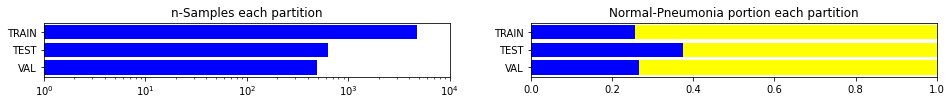

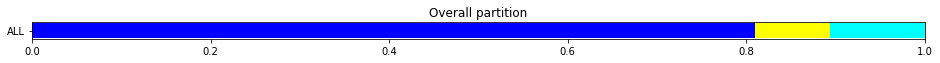

In [ ]:
#@title samples partition after restructure { display-mode: "form" }

NB_TRAIN_SAMPLES_N = len(os.listdir(os.path.join(train_img_dir, 'NORMAL')))
NB_TRAIN_SAMPLES_P = len(os.listdir(os.path.join(train_img_dir, 'PNEUMONIA')))
NB_TRAIN_SAMPLES = NB_TRAIN_SAMPLES_N + NB_TRAIN_SAMPLES_P

NB_VAL_SAMPLES_N = len(os.listdir(os.path.join(val_img_dir, 'NORMAL')))
NB_VAL_SAMPLES_P = len(os.listdir(os.path.join(val_img_dir, 'PNEUMONIA')))
NB_VAL_SAMPLES = NB_VAL_SAMPLES_N + NB_VAL_SAMPLES_P

NB_TEST_SAMPLES_N = len(os.listdir(os.path.join(test_img_dir, 'NORMAL')))
NB_TEST_SAMPLES_P = len(os.listdir(os.path.join(test_img_dir, 'PNEUMONIA')))
NB_TEST_SAMPLES = NB_TEST_SAMPLES_N + NB_TEST_SAMPLES_P

NB_TOTAL_SAMPLES = NB_TRAIN_SAMPLES + NB_VAL_SAMPLES + NB_TEST_SAMPLES

chart_partitioning()

- The current test set has different class proportion, not too different, and still can be assume are in the same distribution

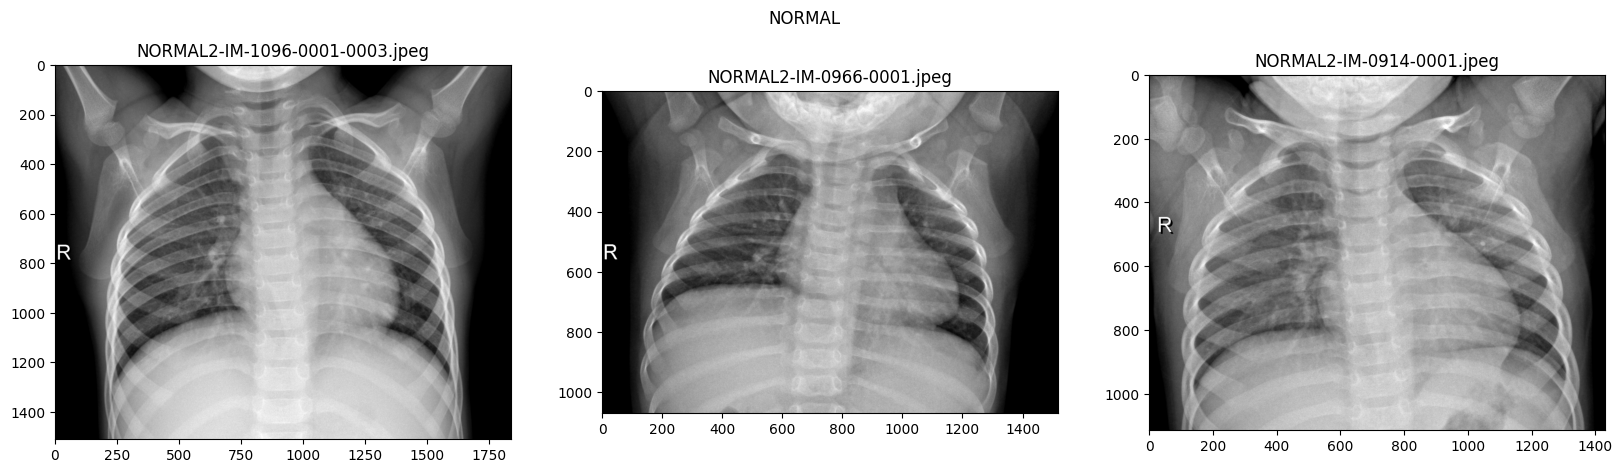

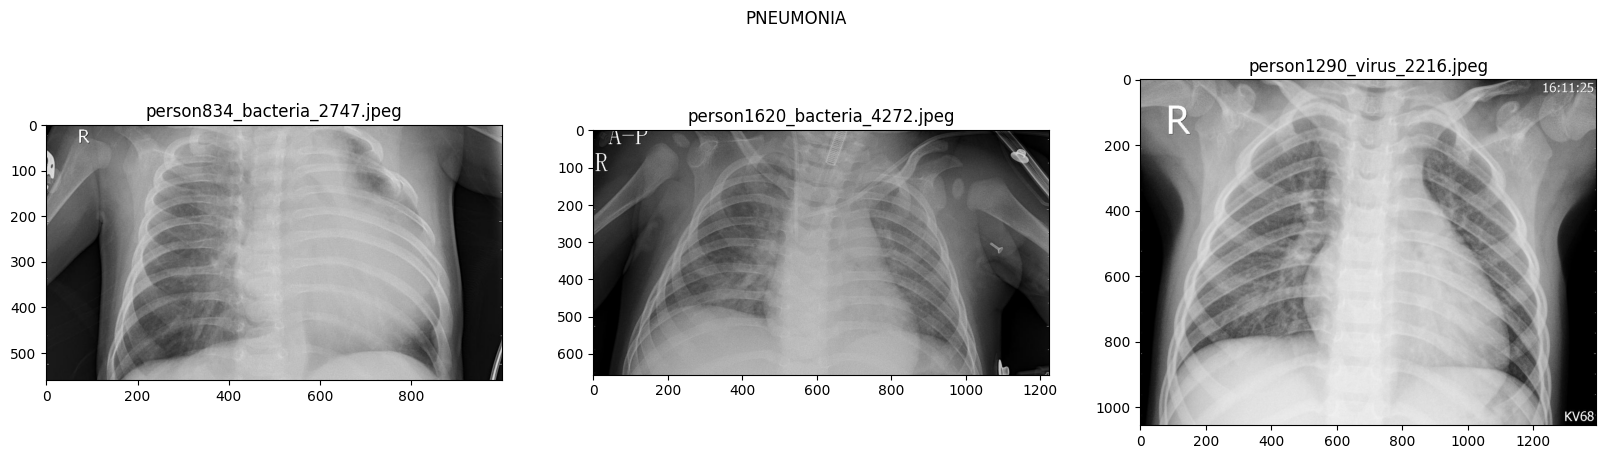

In [9]:
#@title show some images { display-mode: "form" }

img_normal = []
img_pneumonia = []
for img_dir in [test_img_dir, train_img_dir, val_img_dir]:
  for dirname, _, filenames in os.walk(os.path.join(img_dir, 'NORMAL')):
    for filename in filenames:
        img_normal.append(os.path.join(dirname, filename))
  for dirname, _, filenames in os.walk(os.path.join(img_dir, 'PNEUMONIA')):
    for filename in filenames:
        img_pneumonia.append(os.path.join(dirname, filename))

fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax = ax.flatten()
plt.suptitle("NORMAL")
for i, j in enumerate(np.random.randint(len(img_normal), size=3).tolist()):
  ax[i].imshow(load_img(img_normal[j]))
  ax[i].set_title(img_normal[j].split('/')[-1]);

fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax = ax.flatten()
plt.suptitle("PNEUMONIA")
for i, j in enumerate(np.random.randint(len(img_pneumonia), size=3).tolist()):
  ax[i].imshow(load_img(img_pneumonia[j]))
  ax[i].set_title(img_pneumonia[j].split('/')[-1]);

From the pictures, I can tell you there are differences in the rib cage shape of the patient who has pneumonia compared to normal chest.
- Somehow the x-ray return more clear image in normal person and foggy image in infected.
- Also, normal chest is relatively symetric between the right and the left part.

Know the case :
- When interpreting the x-ray, the radiologist will look for **white spots** in the lungs (called infiltrates) that identify an infection. This exam will also help determine if you have any complications related to pneumonia such as abscesses or pleural effusions (**fluid surrounding the lungs**).  [[source]](https://www.radiologyinfo.org/en/info.cfm?pg=pneumonia)
- Pneumonia is a very common disease. It can be either: 1) Bacterial pneumonia 2) Viral Pneumonia 3) Mycoplasma pneumonia and 4) Fungal pneumonia. This dataset consists pneumonia samples belonging to the first two classes.

# Data Generator

In [10]:
#@title set epoch, batch_size { display-mode: "form" }

EPOCHS = 7 #@param {type:"slider", min:5, max:30, step:1}
BATCH_SIZE =  100#@param {type:"number"}

In [12]:
IMG_WIDTH, IMG_HEIGHT = 150, 150

train_datagen = ImageDataGenerator(
                   rescale=1./255,
                   rotation_range=8,  # degrees
                   zoom_range=0.1,
                   width_shift_range=0.08,  # per cent width
                   height_shift_range=0.08,  # per cent height
                   horizontal_flip=False,
                   vertical_flip=False,
                   shear_range=0.02,
                   )

train_generator = train_datagen.flow_from_directory(
                                   train_img_dir,
                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                   batch_size=BATCH_SIZE,
                                   class_mode='binary',
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)

val_generator = test_datagen.flow_from_directory(
                                val_img_dir,
                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                batch_size=BATCH_SIZE,
                                class_mode='binary',
                                )

test_generator = test_datagen.flow_from_directory(
                                test_img_dir,
                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                batch_size=32,
                                shuffle=False,
                                class_mode='binary',
                                )

Found 4743 images belonging to 2 classes.
Found 489 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


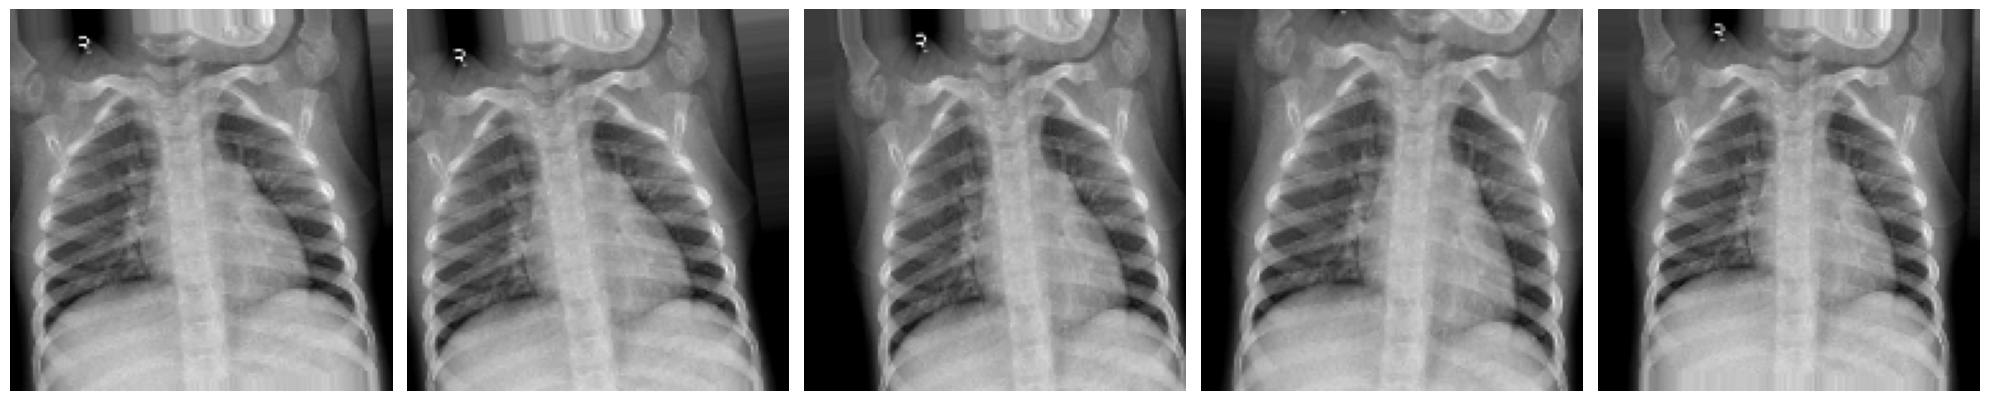

In [13]:
#@title check posibilities of augmented images at training dataset { display-mode: "form" }

flow_n = 1 #@param {type:"slider", min:0, max:10, step:1}
idx_m = 10 #@param {type:"slider", min:0, max:99, step:1}

# This function will plot augmented images
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show();

plotImages([train_generator[flow_n][0][idx_m] for i in range(5)])

- To resize the image so that all of the images have the same form: width of 150 and height of 150
- ImageDataGenerator augmentation might causes "bleeding" and crop important feature.
- It is crucial the chest area are fully included in the image. While in some images, the chest area is just fit so perfectly that even tiny slight parameter may crop them.

# Create Model

In [14]:
#@title set optimizer and learning_rate{ display-mode: "form" }

optimizer = "RMSprop" #@param ["adam", "RMSprop"]
learning_rate = 0.0008 #@param {type:"number"}

optimizer = Adam(learning_rate=learning_rate) if optimizer == "adam" \
              else RMSprop(learning_rate=learning_rate)

In [15]:
inputs = Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3))
model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
               input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))(inputs)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Flatten()(model)
model = Dense(activation='relu', units=128)(model)
outputs = Dense(activation='sigmoid', units=1)(model)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

loss = 'binary_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,318,817 (20.29 MB)

 Trainable params: 5,318,817 (20.29 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
gc.collect()

9951

# Fit Model

In [19]:
# Check your validation generator to ensure it yields data
for data_batch, labels_batch in val_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

# Check the value of NB_VAL_SAMPLES to make sure it is not zero.
print(f'NB_VAL_SAMPLES: {NB_VAL_SAMPLES}')

# Temporarily increase validation_steps to a larger number to see if
# the generator yields any data
history = model.fit(
                  train_generator,
                  steps_per_epoch=NB_TRAIN_SAMPLES//BATCH_SIZE+1,
                  epochs=EPOCHS,
                  validation_data=val_generator,
                  validation_steps=100, # Temporarily increase validation steps
                  # callbacks=,
                  )

data batch shape: (100, 150, 150, 3)
labels batch shape: (100,)
NB_VAL_SAMPLES: 16
Epoch 1/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9063 - loss: 0.2559 - val_accuracy: 0.9550 - val_loss: 0.1314
Epoch 2/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9219 - loss: 0.2003 - val_accuracy: 0.9509 - val_loss: 0.1211
Epoch 3/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9271 - loss: 0.1899 - val_accuracy: 0.9468 - val_loss: 0.1267
Epoch 4/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9338 - loss: 0.1800 - val_accuracy: 0.9571 - val_loss: 0.1269
Epoch 5/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9284 - loss: 0.1765 - val_accuracy: 0.9530 - val_loss: 0.1160
Epoch 6/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9295 - loss: 0.1776 - val_accuracy: 0.9550 - val_loss: 0.1131
Epoch 7/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9404 - loss: 0.1564 - val_accuracy: 0.9468 - val_loss: 0.1390


In [20]:
score = model.evaluate(test_generator,
                       steps=NB_TEST_SAMPLES//32+1,
                       )

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.6917 - loss: 0.7563


In [21]:
#@title save model and log { display-mode: "form" }

# save model
timestamp = datetime.strftime(datetime.now(), "%m%d_%H%m")  #month day hour min
model_fname = f"sequential_{timestamp}"; display(model_fname)
# model.save(model_fname, save_format='h5')

log = {}
log['history'] = history.history
log['score'] = {'loss':score[0], 'accuracy':score[1]}
log['params'] = {'epoch':EPOCHS, 'batch_size':BATCH_SIZE,
                 'optimizer':str(optimizer), 'learning_rate': learning_rate,
                 'loss':loss, 'metrics':str(metrics)}
log_fname = f"log_{timestamp}.json"; display(log_fname)

with open(log_fname, 'w') as f:
  json.dump(log, f)

'sequential_0930_0809'

'log_0930_0809.json'

# Evaluation

In [22]:
#@title define functions: plot_metrics { display-mode: "form" }

import seaborn as sns
sns.set(style='whitegrid')

def plot_metrics(fp, is_url=True):

  if is_url!=True:
    log = json.load(open(fp, 'r'))
  else:
    response = requests.get(fp)
    log = response.json()

  acc = log['history']['accuracy']
  loss = log['history']['loss']
  val_acc = log['history']['val_accuracy']
  val_loss = log['history']['val_loss']

  fig = plt.figure(figsize=(12, 6))

  ax = fig.add_subplot(1,2,1)
  ax.plot(np.arange(1,len(acc)+1), acc, label='train_accuracy')
  ax.plot(np.arange(1,len(val_acc)+1), val_acc, label='val_accuracy')
  ax.legend(loc='lower right')
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epoch #')
  ax.grid()

  ax = fig.add_subplot(1,2,2)
  ax.plot(np.arange(1,len(loss)+1), loss, label='train_loss')
  ax.plot(np.arange(1,len(val_loss)+1), val_loss, label='val_loss')
  ax.legend(loc='upper right')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epoch #')
  ax.yaxis.tick_right()
  ax.yaxis.set_label_position("right")
  ax.grid();

---
[1] Adam(learning_rate=0.001) batch=100, epoch=20
- The training score seems better than a previous partitioning contain only 16 sample of validation partion. The metrics converge in less noise.
- Training accuracy is good but it seems overfitting since the test accucary is around ~0.7. Since we know more than 60% of the test set is Pnumonia class, that value is somehow not much different to predict all image as Pneumonia.
- Confusion matrix indicate poor precision that the model is simply predict image as pneumonia.
---


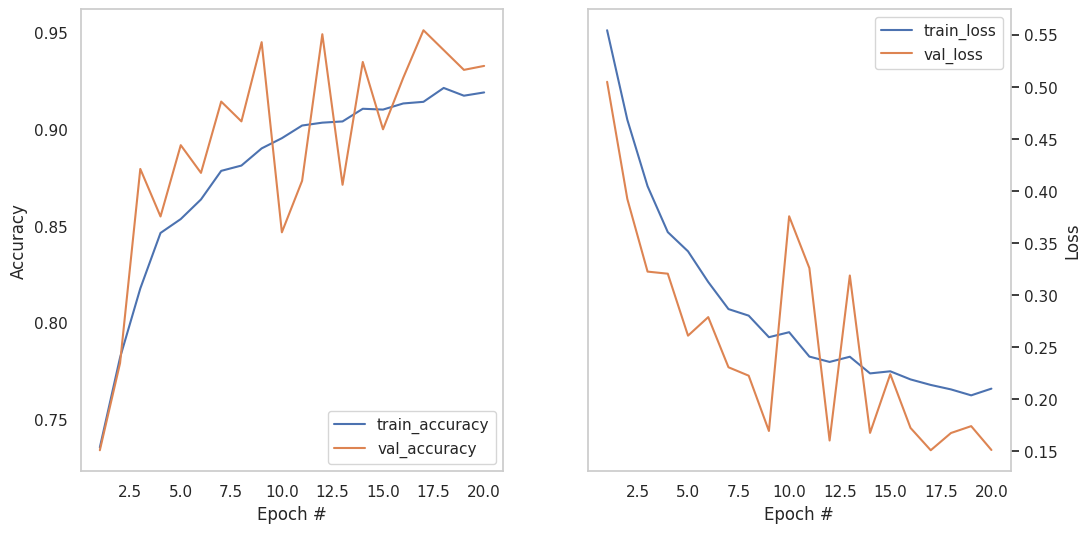

In [23]:
#@title show result plot_metrics
url = 'https://raw.githubusercontent.com/fadheladlansyah/chest-xray-pneumonia/master/log/log_0405_0604.json'
plot_metrics(url, is_url=True)

---
[2] RMSProp(learning_rate=0.0001), batch=100, epoch=20
- The training way better in small learning_rate and converged. Should try more epoch
- The test result by looing confusion matrix is also good enough to result low recall
- Even better when the model can correctly predict 3 out of 4 image from other resource
---


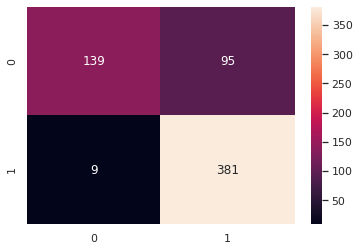

In [24]:
#@title show result plot_metrics
img_url = 'https://raw.githubusercontent.com/fadheladlansyah/chest-xray-pneumonia/master/image/cm_0405_0904.png'
response = requests.get(img_url)
load_img(BytesIO(response.content))

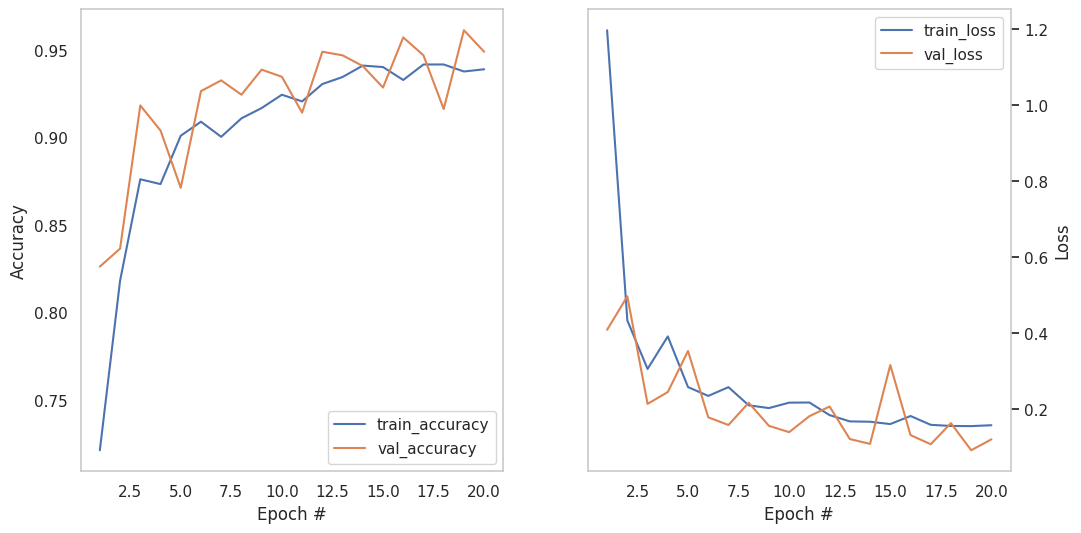

In [25]:
#@title show result plot_metrics
url = 'https://raw.githubusercontent.com/fadheladlansyah/chest-xray-pneumonia/master/log/log_0405_0904.json'
plot_metrics(url, is_url=True)

---
[3] RMSProp(learning_rate=0.00008), batch=100, epoch=25
- Try more epoch with bit lower learning rate. The result is even better
- But the model correctly predict 2 out of 4 image from other resource. End here.
---

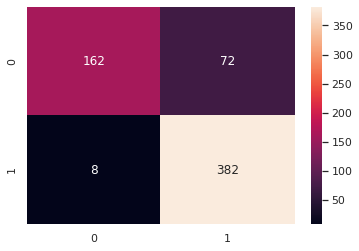

In [26]:
#@title show result plot_metrics
img_url = 'https://raw.githubusercontent.com/fadheladlansyah/chest-xray-pneumonia/master/image/cm_0405_1104.png'
response = requests.get(img_url)
load_img(BytesIO(response.content))

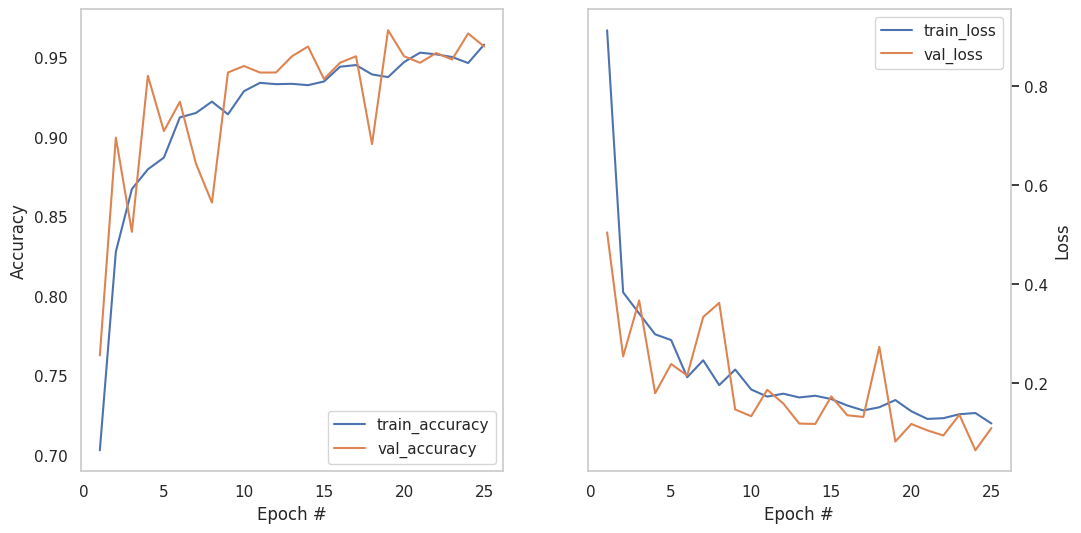

In [27]:
#@title show result plot_metrics
url = 'https://raw.githubusercontent.com/fadheladlansyah/chest-xray-pneumonia/master/log/log_0405_1104.json'
plot_metrics(url, is_url=True)

---
Restart and re-run
---

Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step


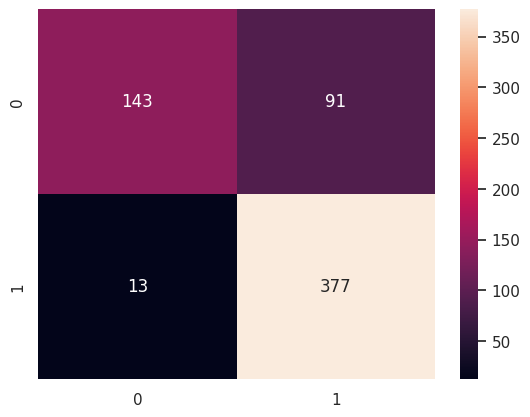

In [28]:
#@title confusion matrix on test dataset { display-mode: "form" }

import seaborn as sns
sns.set(style='whitegrid')

preds = model.predict(test_datagen.flow_from_directory(
                                test_img_dir,
                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                batch_size=32,
                                shuffle=False,
                                class_mode='binary'
                                ),
                      steps=NB_TEST_SAMPLES//32+1)

labels = np.vstack([np.zeros(shape=(NB_TEST_SAMPLES_N,1)),
                    np.ones(shape=(NB_TEST_SAMPLES_P,1))])

# Get the confusion matrix
cm  = tf.math.confusion_matrix(labels.flatten(), np.round(preds).flatten())
ax = sns.heatmap(cm.numpy(), annot=True, fmt="d")

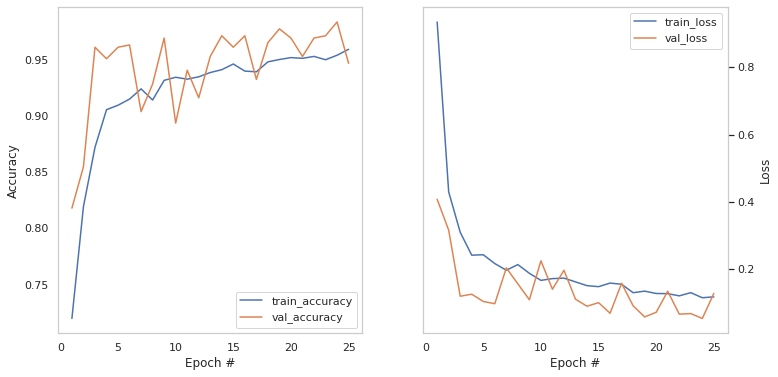

In [ ]:
#@title show result plot_metrics
plot_metrics(log_fname, is_url=False)

# Extras

to check with other source

In [29]:
# try image from other source

url_list = [
            # https://radiopaedia.org/cases/normal-chest-x-ray
            "https://prod-images-static.radiopaedia.org/images/220869/76052f7902246ff862f52f5d3cd9cd_jumbo.jpg",
            # https://radiopaedia.org/cases/normal-chest-x-ray-1
            "https://prod-images-static.radiopaedia.org/images/8686421/17baee9bfb9018e3d109ec63cb380e_jumbo.jpeg",
            # https://radiopaedia.org/cases/lobar-pneumonia?lang=us
            "https://prod-images-static.radiopaedia.org/images/27547404/4e1dc09c3abe03a3efb72d494ddb6f_jumbo.jpeg",
            # https://radiopaedia.org/cases/round-pneumonia-8?lang=us
            "https://prod-images-static.radiopaedia.org/images/2394007/5d72614a0bb470df028956a4d303b0_jumbo.jpg",
            ]

# uploaded = files.upload()

# for fn in uploaded.keys():
#   path = '/content/' + fn
#   img = load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT))
#   img = img_to_array(img)
#   img = np.expand_dims(img, axis=0)

for url in url_list:

  response = requests.get(url)
  # img = Image.open(BytesIO(response.content))
  img = load_img(BytesIO(response.content), target_size=(IMG_WIDTH, IMG_HEIGHT))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)

  classes = model.predict(img, batch_size=10)
  print(classes[0][0])
  if classes[0][0]>0.5:
    print(url + " is PNEUMONIA case")
  else:
    print(url + " is NORMAL case")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
0.0
https://prod-images-static.radiopaedia.org/images/220869/76052f7902246ff862f52f5d3cd9cd_jumbo.jpg is NORMAL case
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0.0
https://prod-images-static.radiopaedia.org/images/8686421/17baee9bfb9018e3d109ec63cb380e_jumbo.jpeg is NORMAL case
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.0
https://prod-images-static.radiopaedia.org/images/27547404/4e1dc09c3abe03a3efb72d494ddb6f_jumbo.jpeg is NORMAL case
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.0
https://prod-images-static.radiopaedia.org/images/2394007/5d72614a0bb470df028956a4d303b0_jumbo.jpg is NORMAL case


Well, I can surely say it's still **far from good**.